In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import RunLocks, Noxaxis, CheckLinearity
from finesse.analysis.actions import SensingMatrixDC, OptimiseRFReadoutPhaseDC
from finesse import ligo
from LLOF3NoSqz import make_LLO

finesse.configure(plotting=True)

In [2]:
LLO = finesse.Model()
LLO.parse_file("./LIGO_degisn.txt")
# LLO.Mloss.value = 3.75e-05
LLO.modes(maxtem=0)
# LLO.unparse_file("./LLONoOutputOptics.txt", inplace=True)
LLO = make_LLO(LLO)
# LLO.modes("off")

In [5]:
# LLO.unparse()

In [29]:
LLOErrorSignal = LLO.deepcopy()

sol_matrix = LLOErrorSignal.run(SensingMatrixDC(["CARM", "DARM", "DARM", "SRCL", "PRCL", "MICH",],
                                     ["REFL9", "AS45", "AS", "POP45", "POP9", "POP45",]))

print("Sensing Matrix:", sol_matrix, end="\n\n", sep="\n")

Sensing Matrix:
╒══════╤═══════════╤═══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════╤══════════╤══════════╤═══════════╤═══════════╕
│      │   REFL9_I │   REFL9_Q │   AS45_I │   AS45_Q │    AS_DC │   POP45_I │   POP45_Q │   POP9_I │   POP9_Q │   POP45_I │   POP45_Q │
╞══════╪═══════════╪═══════════╪══════════╪══════════╪══════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════╪═══════════╡
│ CARM │   2.1E+03 │   1.2E+02 │  0.32    │  0.023   │  1.1E-05 │  12       │  -0.91    │ 33       │ -4.8     │  12       │  -0.91    │
├──────┼───────────┼───────────┼──────────┼──────────┼──────────┼───────────┼───────────┼──────────┼──────────┼───────────┼───────────┤
│ DARM │   0.0099  │   0.00058 │  1E+02   │  7.1     │ 31       │   4.8E-05 │   8E-05   │  0.00016 │ -2.2E-05 │   4.8E-05 │   8E-05   │
├──────┼───────────┼───────────┼──────────┼──────────┼──────────┼───────────┼───────────┼──────────┼──────────┼───────────┼───────────┤
│ DARM │   0.0099  │   0.00058 │

In [36]:
result = np.abs(sol_matrix.out)
df = pd.DataFrame(result, columns=["REFL9_I", "AS45_I", "AS_DC", "POP45_I", "POP9_I", "POP45_Q"], 
                 index=["CARM", "DARM_RF", "DARM_DC", "SRCL", "PRCL", "MICH",])
pd.set_option('display.precision', 5)
df

,REFL9_I,AS45_I,AS_DC,POP45_I,POP9_I,POP45_Q
CARM,2100.38093,0.32059,1.05419e-05,12.10370,32.92062,12.10370
DARM_RF,0.00987,101.68866,3.10623e+01,0.00009,0.00016,0.00009
DARM_DC,0.00987,101.68866,3.10623e+01,0.00009,0.00016,0.00009
SRCL,0.00014,0.00006,1.04083e-08,0.00386,0.00001,0.00386
PRCL,3.22588,0.00057,1.35308e-07,0.02188,0.07308,0.02188
MICH,2.26434,0.26751,8.18690e-02,0.02197,0.05240,0.02197


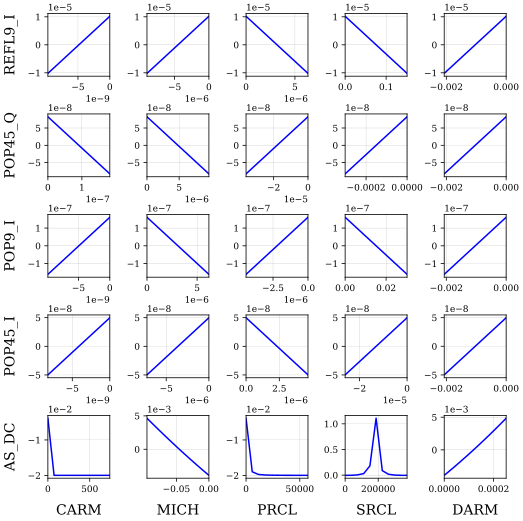

In [12]:
sol_linear = LLOErrorSignal.run(CheckLinearity(plot_results=True))

In [7]:
LLOErrorSignal = LLO.deepcopy()
# LLOQNLS.SRCL.DC = 90
LLOErrorSignal.parse("""
readout_rf POP45new PRMAR.p1.o   f=&f2 phase=177.83524272452797 output_detectors=true
xaxis(SRCL.DC, lin, -100, 100, 200, name='xaxis3')
""")

outLLOErrorSignalSRC = LLOErrorSignal.run()

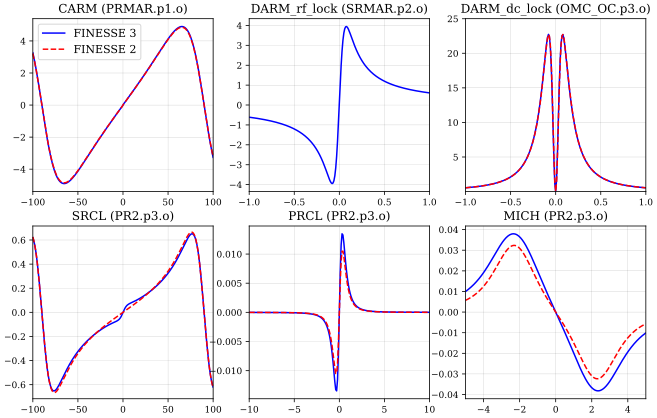

In [9]:
LLOErrorSignal = LLO.deepcopy()
# LLOQNLS.SRCL.DC = 90
LLOErrorSignal.parse("""
readout_rf POP45new PRMAR.p1.o   f=&f2 phase=177.83524272452797 output_detectors=true

series(
    xaxis(CARM.DC, lin, -100, 100, 200, name='xaxis1'),
    xaxis(DARM.DC, lin, -1, 1, 200, name='xaxis2', relative=True),
    xaxis(SRCL.DC, lin, -100, 100, 200, name='xaxis3'),
    xaxis(PRCL.DC, lin, -10, 10, 200, name='xaxis4'),
    xaxis(MICH2.DC, lin, -5, 5, 200, name='xaxis5'),
)
""")

outLLOErrorSignal = LLOErrorSignal.run()

errorSignalsF2 = np.load("../F2 code/errorSignals.npy")
DOFs = ["CARM (PRMAR.p1.o)", "DARM_rf_lock (SRMAR.p2.o)", "DARM_dc_lock (OMC_OC.p3.o)", 
        "SRCL (PR2.p3.o)", "PRCL (PR2.p3.o)", "MICH (PR2.p3.o)",]
Signals = ["REFL9_I", "AS45_I", "AS_DC", "POP45new_I", "POP9_I", "POP45_Q",]
# Signals = ["REFL9_I", "AS45_I", "AS_DC", "POP45_I", "POP9_I", "POP45_Q",]

x1 = np.linspace(-100, 100, num=201)
x2 = np.linspace(-1, 1, num=201)
x3 = np.linspace(-100, 100, num=201)
x4 = np.linspace(-10, 10, num=201)
x5 = np.linspace(-5, 5, num=201)

fig, axes = plt.subplots(2, 3, figsize=(11, 7))

index = 0
for i in range(2):
    for j in range(3):
#         if index > 4:
#             axes[i, j].spines['top'].set_visible(False)
#             axes[i, j].spines['right'].set_visible(False)
#             axes[i, j].spines['bottom'].set_visible(False)
#             axes[i, j].spines['left'].set_visible(False)
#             axes[i, j].get_xaxis().set_ticks([])
#             axes[i, j].get_yaxis().set_ticks([])
#             break
        
        axes[i, j].set_title(DOFs[index])

        if index == 0:
            x = outLLOErrorSignal[f'xaxis1'].x[0]
            y = outLLOErrorSignal[f'xaxis1'][Signals[index]]
            axes[i, j].plot(x, y, label="FINESSE 3")
            axes[i, j].plot(eval(f"x1"), errorSignalsF2[0], '--', label="FINESSE 2")
            axes[i, j].legend(loc="best", fontsize=11);
        elif index == 1 or index == 2:
            x = outLLOErrorSignal[f'xaxis2'].x[0]
            y = outLLOErrorSignal[f'xaxis2'][Signals[index]]
            axes[i, j].plot(x, y)
            if index == 2:
                axes[i, j].plot(eval(f"x2"), errorSignalsF2[1], '--')
            
        else:
            x = outLLOErrorSignal[f'xaxis{index}'].x[0]
            y = outLLOErrorSignal[f'xaxis{index}'][Signals[index]]
            axes[i, j].plot(x, y)
            axes[i, j].plot(eval(f"x{index}"), errorSignalsF2[index-1], '--')
        
        mmin = y.min()*(1+0.1)
        mmax = y.max()*(1+0.1)
    
        axes[i, j].set_ylim(mmin, mmax)
        index += 1

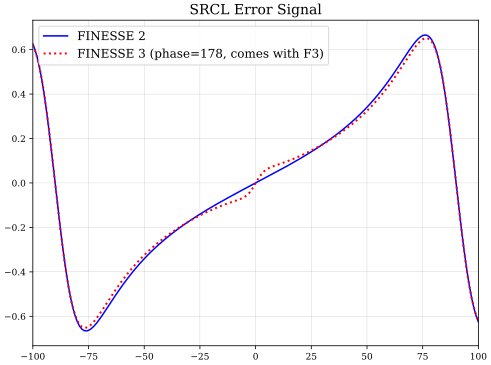

In [10]:
plt.figure(figsize=(8,6))
plt.plot(x3, errorSignalsF2[2], label="FINESSE 2 ")
# plt.plot(x3, outLLOErrorSignalSRCL["POP45New_I"], label="FINESSE 3 (PRMAR.p1.o)", ls=":")
plt.plot(x3, outLLOErrorSignalSRC["POP45new_I"], label="FINESSE 3 (phase=178, comes with F3)", ls=":", lw=2)
# plt.plot(x3, outLLOErrorSignalSRCL["POP45NewP_I"], label="FINESSE 3 (phase=188)", ls=":", lw=2)
# plt.plot(x3, outLLOErrorSignalSRCL["POP45NewM_I"], label="FINESSE 3 (phase=168)", ls=":", lw=2)

plt.legend(fontsize=12, loc="best")

plt.title("SRCL Error Signal", fontsize=14);